# Singleモデルにおける画像の埋め込みとtopK計算用

In [6]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import load_model

In [7]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

In [8]:
import os
BASE_PATH = './dataset/Pants_all/'

In [9]:
model_epoch = 99
ALPHA = 0.1
BETA = 0.05
vec_length = 512
category = 'Pants'

In [33]:
# model_dir = './model/{}/Single_improved/a{}b{}/{}'.format(category,ALPHA,BETA,vec_length)
# model_dir = './model/{}/Single_normal/a{}/{}'.format(category,ALPHA,vec_length)
model_dir = './model/{}/Single_improved/a{}b{}/{}'.format(category,ALPHA,BETA,vec_length)
# os.listdir(model_dir)

In [34]:
con_embNet = load_model(model_dir+'/con_e{}.h5'.format(model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/shop_e{}.h5'.format(model_epoch), compile=False)

In [35]:
# con_embNet = load_model(model_dir+'/con_emb_e{}.h5'.format(model_epoch), compile=False)
# shop_embNet = load_model(model_dir+'/shop_emb_e{}.h5'.format(model_epoch), compile=False)

生成済みのpickleを利用するため`datagen.py`は使わない

In [36]:
f = open("./pickle/{}/test_pairs.pickle".format(category),"rb")
test_pairs = pickle.load(f)

In [37]:
test_pairs[0]

[20455,
 ['./dataset/Pants_all/id_00020455/comsumer_01.jpg',
  './dataset/Pants_all/id_00020455/shop_01.jpg']]

In [38]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [39]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[20455, './dataset/Pants_all/id_00020455/shop_01.jpg']
gallery length = 894


In [40]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(894, 512)
(894,)


In [41]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict(np.expand_dims(img,axis=0))[0]

100%|██████████| 894/894 [00:05<00:00, 163.91it/s]


In [42]:
f = open(model_dir+'/gallery{}.txt'.format(model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [43]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [44]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(894,)


In [45]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([20455., 22017., 10211., 23875.,  6604.])

In [46]:
N = 50

In [47]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 894/894 [00:12<00:00, 73.61it/s]


In [48]:
topN_id_list[0]

array([31435., 10970., 27441.,  5018., 31873., 33333., 29795.,  5034.,
       30218.,  8627.,  7039., 12553., 26290., 10761., 29020.,  7975.,
       31718.,  6924., 32873., 19478., 18523., 29206., 26155.,  1453.,
       30119.,  5753.,  2449., 27920.,  2839.,   355.,  2163.,  1505.,
        5424., 13066.,  4147.,  3402., 27663.,  8174., 15638., 30291.,
       13349.,  6178., 33696.,  7857.,  5499., 17414.,  2476.,  3435.,
       27649., 14243.])

In [49]:
f = open(model_dir+'/topN_id_list{}.txt'.format(model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [50]:
f = open(model_dir+'/query{}.txt'.format(model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [51]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [52]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [56]:
f = open(model_dir+'/topk_vals.txt'.format(model_epoch), 'wb')
pickle.dump(topk_vals, f)

In [54]:
topk_vals

[0.011185682326621925,
 0.021252796420581657,
 0.03131991051454139,
 0.04138702460850112,
 0.05145413870246085,
 0.05704697986577181,
 0.06152125279642058,
 0.07270693512304251,
 0.07606263982102908,
 0.08053691275167785,
 0.09284116331096197,
 0.09619686800894854,
 0.1017897091722595,
 0.10626398210290827,
 0.11185682326621924,
 0.11297539149888143,
 0.11521252796420582,
 0.11968680089485459,
 0.12639821029082773,
 0.13087248322147652,
 0.1331096196868009,
 0.13646532438478748,
 0.1476510067114094,
 0.15436241610738255,
 0.15548098434004473,
 0.16331096196868009,
 0.17225950782997762,
 0.18120805369127516,
 0.18680089485458612,
 0.19239373601789708,
 0.19463087248322147,
 0.20022371364653244,
 0.20134228187919462,
 0.2058165548098434,
 0.21252796420581654,
 0.21923937360178972,
 0.22371364653243847,
 0.22930648769574943,
 0.232662192393736,
 0.2371364653243848,
 0.23937360178970918,
 0.24608501118568232,
 0.2483221476510067,
 0.2550335570469799,
 0.2606263982102908,
 0.263982102908277

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


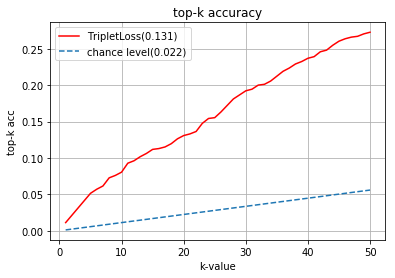

In [55]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level({})'.format(round(chancelv[19],3)))

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()